In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import wandb
# Load the dataset
data = pd.read_csv('WineQT.csv', header=0)


In [2]:
# Calculate statistics
statistics = data.describe()
print(statistics)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

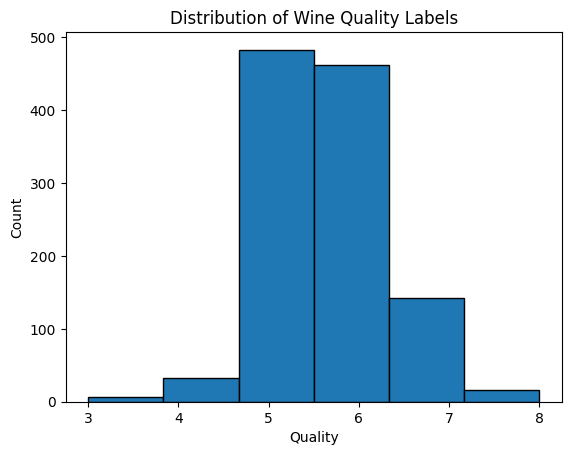

In [3]:
plt.hist(data['quality'], bins=6, edgecolor='k')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality Labels')
plt.show()

In [4]:
# Split the dataset into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.4,random_state = 42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state = 42)
# test_data, validation_data = train_test_split(temp_data, test_size=0.5, random_state = 42)
# print(train_data)


In [5]:
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Fit and transform on the training data
imputer = SimpleImputer(strategy='mean')  # You can choose 'mean', 'median', or other strategies

# Fit and transform on the training data
train_data_scaled = scaler.fit_transform(imputer.fit_transform(train_data.drop(columns=['quality'])))
train_labels = train_data['quality']

# Transform the validation and test data using the same scalers and imputer
validation_data_scaled = scaler.transform(imputer.transform(validation_data.drop(columns=['quality'])))
test_data_scaled = scaler.transform(imputer.transform(test_data.drop(columns=['quality'])))

# If you also want to normalize the data, you can do it using the MinMaxScaler
train_data_scaled_normalized = minmax_scaler.fit_transform(train_data_scaled)
validation_data_scaled_normalized = minmax_scaler.transform(validation_data_scaled)
test_data_scaled_normalized = minmax_scaler.transform(test_data_scaled)

# print(train_labels)
print(train_data_scaled_normalized.shape)
print(test_data_scaled_normalized.shape)
print(validation_data_scaled_normalized.shape)

(685, 12)
(229, 12)
(229, 12)


In [6]:
class MultinomialLogisticRegression:
    def __init__(self, num_classes, learning_rate=0.005, num_epochs=5000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_pred.shape[0]
        # print(y_pred)
        # print(np.log(y_pred))
        return -np.sum(np.log(y_pred) * y_true) / m

    def fit(self, X_train, y_train):
        m, n = X_train.shape
        self.weights = np.zeros((n, self.num_classes+1))
        self.bias = np.zeros((1, self.num_classes+1))
        # print(self.bias)
        for epoch in range(self.num_epochs):
            # print(X_train)
            # print(self.weights)
            z = np.dot(X_train, self.weights) + self.bias
            y_pred = self.softmax(z)

            y_train_encoded = np.eye(self.num_classes+1)[y_train]  # One-hot encoding
            # y_train_encoded = pd.get_dummies(y_train).values.astype(int)
            # print(y_train_encoded)
            loss = self.cross_entropy_loss(y_pred, y_train_encoded)

            # Compute gradients
            dz = y_pred - y_train_encoded
            dw = np.dot(X_train.T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # if epoch % 100 == 0:
            #     print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)

    def evaluate(self, X_val, y_val):
        y_pred = self.predict(X_val)
        accuracy = np.mean(y_pred == y_val)
        return accuracy

In [7]:
# Assuming you have your training and validation data
X_train = train_data_scaled
y_train = train_labels
X_val = validation_data_scaled
y_val = validation_data['quality']
y_train = np.array(y_train)
y_val = np.array(y_val)
print(np.array(y_train).shape)
# print(y_train)
# print(y_train[0])
# Create an instance of the model
num_classes = 8
model = MultinomialLogisticRegression(num_classes=num_classes)
model.fit(X_train, y_train)

# Evaluate the model on validation data
y_pred = model.predict(X_val)
accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(y_pred)
print(y_val)
report = classification_report(y_val, y_pred)
print(report)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
y_train_pred = model.predict(X_train)
report = classification_report(y_train, y_train_pred)
print(report)

(685,)
Validation Accuracy: 63.76%
[5 7 5 5 6 6 6 5 5 5 6 5 6 6 5 6 5 6 5 6 5 5 5 6 6 6 6 5 6 5 6 6 6 5 6 5 6
 5 5 6 6 6 6 5 5 5 6 5 6 5 5 5 5 5 5 5 6 6 7 6 6 6 5 6 7 5 6 5 5 6 6 6 6 5
 5 5 6 5 5 5 6 5 5 6 5 5 6 5 5 5 5 5 6 6 6 7 6 5 5 6 6 6 7 5 6 6 7 6 5 6 7
 6 6 7 6 5 6 5 6 6 5 5 6 6 6 5 6 5 6 5 6 6 5 7 5 6 5 5 5 5 6 7 5 5 5 5 5 6
 6 5 5 5 6 5 5 5 6 5 5 5 6 5 5 5 6 6 5 5 5 6 5 5 6 6 5 6 6 6 6 6 5 7 5 6 5
 5 6 6 7 5 6 5 5 5 6 5 5 7 6 6 5 6 5 6 6 6 6 5 5 6 5 5 5 6 6 5 6 6 5 5 5 6
 6 5 6 5 5 6 5]
[6 7 5 5 7 7 7 5 6 5 6 5 7 6 5 5 5 6 5 6 5 5 5 5 6 6 8 6 6 6 7 6 6 5 6 5 7
 5 6 6 6 5 6 6 5 5 7 5 7 5 5 5 5 5 4 5 5 6 7 4 7 6 5 6 7 4 7 6 4 6 6 6 5 6
 5 5 6 6 6 6 5 5 5 8 6 3 6 5 6 5 5 5 5 6 7 6 7 5 5 6 5 6 7 6 6 6 6 6 5 6 7
 6 5 6 6 7 6 5 5 5 5 6 5 6 7 5 6 5 5 5 7 6 6 7 5 6 6 5 5 6 6 6 6 3 5 5 5 6
 6 5 5 5 6 6 5 5 7 6 5 6 6 5 7 6 5 7 5 6 5 6 3 5 6 6 5 6 6 6 6 6 5 5 7 6 6
 5 5 6 7 5 4 5 5 5 6 5 5 7 6 6 5 5 6 6 7 6 7 5 6 6 5 5 6 6 6 5 5 6 5 5 6 6
 6 5 6 6 5 6 5]
              precision    recall

/home/ubuntulsa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntulsa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntulsa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntulsa/.local/lib/p

In [8]:
wandb.login()

wandb: Network error (ConnectionError), entering retry loop.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [9]:
wandb.init(project="multinomial-logistic-regression-tuning")
# wandb.watch(model, log="all")
learning_rates = [0.001,0.005, 0.01,0.03,0.05,0.0075,0.1,0.2,0.3,0.5]
num_epochs_list = [100, 500, 1000, 5000, 10000]
best_accuracy = 0.0
for learning_rate in learning_rates:
    for num_epochs in num_epochs_list:
        model.learning_rate = learning_rate
        model.num_epochs = num_epochs

        # Train the model
        model.fit(X_train, y_train)

        # Calculate validation accuracy
        val_accuracy = model.evaluate(X_val, y_val)

        # Log results to W&B
        wandb.log({"Learning Rate": learning_rate, "Num Epochs": num_epochs, "Validation Accuracy": val_accuracy})

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_hyperparameters = {"Learning Rate": learning_rate, "Num Epochs": num_epochs}

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)

wandb: Network error (ConnectionError), entering retry loop.


Problem at: /tmp/ipykernel_132473/3093122342.py 1 <module>


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [ ]:
# Assuming you have your training and validation data
X_train = train_data_scaled
y_train = train_labels
X_test = test_data_scaled
y_test = test_data['quality']
y_train = np.array(y_train)
y_test = np.array(y_test)
print(np.array(y_train).shape)
# print(y_train)
# print(y_train[0])
# Create an instance of the model
num_classes = 8
model = MultinomialLogisticRegression(num_classes=num_classes)
model.fit(X_train, y_train)

# Evaluate the model on validation data
y_pred = model.predict(X_test)
accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(y_pred)
print(y_test)
report = classification_report(y_test, y_pred)
print(report)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
y_train_pred = model.predict(X_train)
report = classification_report(y_train, y_train_pred)
print(report)